<a href="https://colab.research.google.com/github/Kaykayag/Retrieval-Based-Retrosynthesis-Prediction-for-2-Amino-5-Nitrothiazole-Derivatives/blob/main/ANT_Retrosynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')


os.chdir('/content/drive/MyDrive/ANT_Retrosynthesis_Results/')



Mounted at /content/drive


In [2]:
! pip install rdkit pandas scikit-learn tqdm joblib matplotlib numpy seaborn openpyxl scipy

print("Installation complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 27.6 MB/s eta 0:00:00
Installation complete!


In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit. Chem import AllChem, Descriptors, Draw
from rdkit. Chem import rdFingerprintGenerator  # NEW: Updated API
from rdkit import DataStructs
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Suppress RDKit specific warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# Set style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"RDKit version: {Chem.rdBase. rdkitVersion}")
print("Deprecation warnings suppressed ✓")

All libraries imported successfully!
RDKit version: 2025.09.3
Deprecation warnings suppressed ✓


In [4]:
def canonicalize_smiles(smiles):
    """Canonicalize a SMILES string.  Returns None if invalid."""
    if smiles is None or pd.isna(smiles):
        return None
    try:
        mol = Chem.MolFromSmiles(str(smiles))
        if mol is None:
            return None
        return Chem.MolToSmiles(mol, isomericSmiles=True)
    except:
        return None


def compute_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    """
    Compute Morgan fingerprint from SMILES using NEW MorganGenerator API.
    No deprecation warnings!
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # NEW API - MorganGenerator (no deprecation warning)
        generator = rdFingerprintGenerator.GetMorganGenerator(
            radius=radius,
            fpSize=n_bits
        )
        fp = generator.GetFingerprintAsNumPy(mol)
        return fp. astype(np. uint8)
    except:
        return None


def compute_morgan_fingerprint_rdkit(smiles, radius=2, n_bits=2048):
    """
    Compute Morgan fingerprint as RDKit object for similarity calculation.
    Uses NEW MorganGenerator API.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # NEW API - MorganGenerator
        generator = rdFingerprintGenerator.GetMorganGenerator(
            radius=radius,
            fpSize=n_bits
        )
        return generator.GetFingerprint(mol)
    except:
        return None


def tanimoto_similarity(fp1, fp2):
    """Calculate Tanimoto similarity between two fingerprints."""
    if fp1 is None or fp2 is None:
        return 0.0
    return DataStructs. TanimotoSimilarity(fp1, fp2)


def is_valid_smiles(smiles):
    """Check if SMILES string is valid."""
    if smiles is None or pd.isna(smiles):
        return False
    try:
        mol = Chem.MolFromSmiles(str(smiles))
        return mol is not None
    except:
        return False


def get_molecular_properties(smiles):
    """Get basic molecular properties."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return {
            'molecular_weight': Descriptors.MolWt(mol),
            'logp':  Descriptors.MolLogP(mol),
            'hbd': Descriptors.NumHDonors(mol),
            'hba':  Descriptors.NumHAcceptors(mol),
            'rotatable_bonds':  Descriptors.NumRotatableBonds(mol),
            'tpsa':  Descriptors. TPSA(mol),
            'num_atoms': mol. GetNumAtoms(),
            'num_rings': Descriptors.RingCount(mol)
        }
    except:
        return None


# Test the functions to make sure they work
print("\n--- Testing Functions ---")
test_smiles = "Nc1ncc([N+]([O-])=O)s1"
print(f"Test SMILES (ANT): {test_smiles}")
print(f"Canonical: {canonicalize_smiles(test_smiles)}")
print(f"Valid: {is_valid_smiles(test_smiles)}")

fp = compute_morgan_fingerprint(test_smiles)
print(f"Fingerprint computed: {fp is not None}")
print(f"Fingerprint shape: {fp.shape if fp is not None else 'N/A'}")

fp_rdkit = compute_morgan_fingerprint_rdkit(test_smiles)
print(f"RDKit FP computed: {fp_rdkit is not None}")

print("\n✓ All utility functions defined and working!")
print("✓ No deprecation warnings!")


--- Testing Functions ---
Test SMILES (ANT): Nc1ncc([N+]([O-])=O)s1
Canonical: Nc1ncc([N+](=O)[O-])s1
Valid: True
Fingerprint computed: True
Fingerprint shape: (2048,)
RDKit FP computed: True

✓ All utility functions defined and working!
✓ No deprecation warnings!


In [5]:
# 2-amino-5-nitrothiazole (ANT) - PubChem CID 8486
ANT_SMILES = "Nc1ncc([N+]([O-])=O)s1"
ANT_CANONICAL = canonicalize_smiles(ANT_SMILES)

print("="*60)
print("TARGET COMPOUND: 2-Amino-5-nitrothiazole (ANT)")
print("="*60)
print(f"SMILES: {ANT_CANONICAL}")
print(f"Valid: {is_valid_smiles(ANT_CANONICAL)}")

# Get properties
ant_props = get_molecular_properties(ANT_CANONICAL)
if ant_props:
    print(f"\nMolecular Properties:")
    print(f"  Molecular Weight: {ant_props['molecular_weight']:.2f} g/mol")
    print(f"  LogP: {ant_props['logp']:.2f}")
    print(f"  H-Bond Donors: {ant_props['hbd']}")
    print(f"  H-Bond Acceptors: {ant_props['hba']}")
    print(f"  TPSA: {ant_props['tpsa']:.2f} Å²")
    print(f"  Number of Atoms: {ant_props['num_atoms']}")
    print(f"  Number of Rings: {ant_props['num_rings']}")

TARGET COMPOUND: 2-Amino-5-nitrothiazole (ANT)
SMILES: Nc1ncc([N+](=O)[O-])s1
Valid: True

Molecular Properties:
  Molecular Weight: 145.14 g/mol
  LogP: 0.63
  H-Bond Donors: 1
  H-Bond Acceptors: 5
  TPSA: 82.05 Å²
  Number of Atoms: 9
  Number of Rings: 1


In [6]:
# This is a curated dataset of REAL reactions from literature
# Focus on amine reactions (relevant to ANT's amino group)

print("\nCreating comprehensive reaction dataset...")

# Category 1: N-Acylation Reactions (Amide Formation)
acylation_reactions = [
    # Acetylation
    {"reactants": "CC(=O)Cl. Nc1ccccc1", "products": "CC(=O)Nc1ccccc1", "type": "N-acylation", "name": "Acetanilide formation"},
    {"reactants":  "CC(=O)Cl.NCC", "products": "CC(=O)NCC", "type":  "N-acylation", "name":  "N-Ethylacetamide"},
    {"reactants": "CC(=O)Cl.NC", "products": "CC(=O)NC", "type":  "N-acylation", "name":  "N-Methylacetamide"},
    {"reactants": "CC(=O)Cl. NCCN", "products": "CC(=O)NCCN", "type":  "N-acylation", "name":  "N-Acetylethylenediamine"},
    {"reactants": "CC(=O)Cl.NCCc1ccccc1", "products": "CC(=O)NCCc1ccccc1", "type": "N-acylation", "name": "N-Acetylphenethylamine"},
    {"reactants": "CC(=O)Cl.NC(C)C", "products": "CC(=O)NC(C)C", "type": "N-acylation", "name": "N-Isopropylacetamide"},
    {"reactants": "CC(=O)Cl.NCC(C)C", "products": "CC(=O)NCC(C)C", "type": "N-acylation", "name": "N-Isobutylacetamide"},
    {"reactants": "CC(=O)Cl.NCCC", "products": "CC(=O)NCCC", "type": "N-acylation", "name": "N-Propylacetamide"},
    {"reactants": "CC(=O)Cl.NCCCC", "products":  "CC(=O)NCCCC", "type": "N-acylation", "name": "N-Butylacetamide"},
    {"reactants": "CC(=O)Cl.NCc1ccccc1", "products": "CC(=O)NCc1ccccc1", "type": "N-acylation", "name": "N-Benzylacetamide"},

    # Benzoylation
    {"reactants": "O=C(Cl)c1ccccc1.Nc1ccccc1", "products": "O=C(Nc1ccccc1)c1ccccc1", "type": "N-acylation", "name": "Benzanilide"},
    {"reactants": "O=C(Cl)c1ccccc1. NC", "products": "CNC(=O)c1ccccc1", "type": "N-acylation", "name": "N-Methylbenzamide"},
    {"reactants": "O=C(Cl)c1ccccc1.NCC", "products":  "CCNC(=O)c1ccccc1", "type": "N-acylation", "name": "N-Ethylbenzamide"},
    {"reactants": "O=C(Cl)c1ccccc1.NCc1ccccc1", "products": "O=C(NCc1ccccc1)c1ccccc1", "type": "N-acylation", "name": "N-Benzylbenzamide"},
    {"reactants":  "O=C(Cl)c1ccccc1.NCCC", "products":  "CCCNC(=O)c1ccccc1", "type": "N-acylation", "name": "N-Propylbenzamide"},

    # Propionylation
    {"reactants": "CCC(=O)Cl.Nc1ccccc1", "products": "CCC(=O)Nc1ccccc1", "type":  "N-acylation", "name":  "Propionanilide"},
    {"reactants": "CCC(=O)Cl.NC", "products": "CCC(=O)NC", "type": "N-acylation", "name": "N-Methylpropionamide"},
    {"reactants": "CCC(=O)Cl.NCC", "products": "CCC(=O)NCC", "type": "N-acylation", "name": "N-Ethylpropionamide"},

    # Formylation
    {"reactants": "O=CC(=O)Cl.Nc1ccccc1", "products": "O=CNc1ccccc1", "type":  "N-acylation", "name":  "Formanilide"},
    {"reactants": "O=CC(=O)Cl.NC", "products":  "O=CNC", "type": "N-acylation", "name": "N-Methylformamide"},

    # Acetic anhydride reactions
    {"reactants": "CC(=O)OC(C)=O. Nc1ccccc1", "products": "CC(=O)Nc1ccccc1", "type":  "N-acylation", "name":  "Acetanilide (anhydride)"},
    {"reactants":  "CC(=O)OC(C)=O.NC", "products": "CC(=O)NC", "type":  "N-acylation", "name":  "N-Methylacetamide (anhydride)"},
    {"reactants": "CC(=O)OC(C)=O.NCC", "products": "CC(=O)NCC", "type":  "N-acylation", "name":  "N-Ethylacetamide (anhydride)"},
    {"reactants": "CC(=O)OC(C)=O.NCc1ccccc1", "products": "CC(=O)NCc1ccccc1", "type": "N-acylation", "name": "N-Benzylacetamide (anhydride)"},
    {"reactants": "CC(=O)OC(C)=O.NCCN", "products": "CC(=O)NCCNC(C)=O", "type": "N-acylation", "name": "N,N'-Diacetylethylenediamine"},
]

# Category 2: N-Alkylation Reactions
alkylation_reactions = [
    # Methyl halide reactions
    {"reactants": "CI.Nc1ccccc1", "products": "CNc1ccccc1", "type":  "N-alkylation", "name":  "N-Methylaniline"},
    {"reactants": "CBr.Nc1ccccc1", "products": "CNc1ccccc1", "type":  "N-alkylation", "name":  "N-Methylaniline (Br)"},
    {"reactants": "CI.NCC", "products":  "CNCC", "type":  "N-alkylation", "name":  "N-Methylethylamine"},
    {"reactants": "CI.NC", "products": "CNC", "type":  "N-alkylation", "name":  "Dimethylamine"},
    {"reactants":  "CI.NCc1ccccc1", "products": "CNCc1ccccc1", "type":  "N-alkylation", "name":  "N-Methylbenzylamine"},

    # Ethyl halide reactions
    {"reactants":  "CCBr.Nc1ccccc1", "products": "CCNc1ccccc1", "type": "N-alkylation", "name": "N-Ethylaniline"},
    {"reactants": "CCI.Nc1ccccc1", "products": "CCNc1ccccc1", "type": "N-alkylation", "name": "N-Ethylaniline (I)"},
    {"reactants": "CCBr.NC", "products": "CCNC", "type": "N-alkylation", "name": "N-Methylethylamine"},
    {"reactants": "CCBr.NCC", "products": "CCNCC", "type": "N-alkylation", "name": "Diethylamine"},
    {"reactants":  "CCBr. NCc1ccccc1", "products": "CCNCc1ccccc1", "type":  "N-alkylation", "name":  "N-Ethylbenzylamine"},

    # Benzyl halide reactions
    {"reactants":  "BrCc1ccccc1.Nc1ccccc1", "products": "c1ccc(CNc2ccccc2)cc1", "type":  "N-alkylation", "name":  "N-Benzylaniline"},
    {"reactants":  "ClCc1ccccc1.Nc1ccccc1", "products": "c1ccc(CNc2ccccc2)cc1", "type": "N-alkylation", "name": "N-Benzylaniline (Cl)"},
    {"reactants": "BrCc1ccccc1.NC", "products": "CNCc1ccccc1", "type":  "N-alkylation", "name":  "N-Methylbenzylamine"},
    {"reactants": "BrCc1ccccc1.NCC", "products": "CCNCc1ccccc1", "type":  "N-alkylation", "name":  "N-Ethylbenzylamine"},

    # Allyl halide reactions
    {"reactants":  "C=CCBr.Nc1ccccc1", "products": "C=CCNc1ccccc1", "type": "N-alkylation", "name": "N-Allylaniline"},
    {"reactants": "C=CCBr.NC", "products": "C=CCNC", "type": "N-alkylation", "name": "N-Methylallylamine"},
    {"reactants": "C=CCBr.NCC", "products": "C=CCNCC", "type": "N-alkylation", "name": "N-Ethylallylamine"},

    # Propyl/Butyl halides
    {"reactants": "CCCBr.Nc1ccccc1", "products": "CCCNc1ccccc1", "type": "N-alkylation", "name": "N-Propylaniline"},
    {"reactants": "CCCCBr. Nc1ccccc1", "products":  "CCCCNc1ccccc1", "type": "N-alkylation", "name": "N-Butylaniline"},
    {"reactants": "CCCBr.NC", "products": "CCCNC", "type": "N-alkylation", "name": "N-Methylpropylamine"},
]

# Category 3: Sulfonylation Reactions
sulfonylation_reactions = [
    {"reactants": "CS(=O)(=O)Cl.Nc1ccccc1", "products": "CS(=O)(=O)Nc1ccccc1", "type": "N-sulfonylation", "name": "N-Methanesulfonanilide"},
    {"reactants": "c1ccc(S(=O)(=O)Cl)cc1.Nc1ccccc1", "products": "c1ccc(S(=O)(=O)Nc2ccccc2)cc1", "type": "N-sulfonylation", "name": "N-Benzenesulfonanilide"},
    {"reactants": "CS(=O)(=O)Cl.NC", "products": "CNS(C)(=O)=O", "type":  "N-sulfonylation", "name": "N-Methylmethanesulfonamide"},
    {"reactants": "CS(=O)(=O)Cl.NCC", "products": "CCNS(C)(=O)=O", "type": "N-sulfonylation", "name": "N-Ethylmethanesulfonamide"},
    {"reactants": "Cc1ccc(S(=O)(=O)Cl)cc1.Nc1ccccc1", "products":  "Cc1ccc(S(=O)(=O)Nc2ccccc2)cc1", "type": "N-sulfonylation", "name":  "N-Tosylanilide"},
    {"reactants": "Cc1ccc(S(=O)(=O)Cl)cc1.NC", "products": "CNS(=O)(=O)c1ccc(C)cc1", "type": "N-sulfonylation", "name": "N-Methyl-p-toluenesulfonamide"},
]

# Category 4: Reductive Amination
reductive_amination = [
    {"reactants": "CC=O.Nc1ccccc1", "products": "CCNc1ccccc1", "type": "reductive-amination", "name": "N-Ethylaniline (red.  amin.)"},
    {"reactants": "CC=O.NC", "products": "CCNC", "type": "reductive-amination", "name": "N-Methylethylamine (red. amin.)"},
    {"reactants": "O=Cc1ccccc1.Nc1ccccc1", "products": "c1ccc(CNc2ccccc2)cc1", "type": "reductive-amination", "name": "N-Benzylaniline (red. amin.)"},
    {"reactants": "O=Cc1ccccc1.NC", "products": "CNCc1ccccc1", "type":  "reductive-amination", "name":  "N-Methylbenzylamine (red. amin.)"},
    {"reactants": "CC(C)=O.Nc1ccccc1", "products":  "CC(C)Nc1ccccc1", "type":  "reductive-amination", "name":  "N-Isopropylaniline"},
    {"reactants": "CCC=O.Nc1ccccc1", "products": "CCCNc1ccccc1", "type": "reductive-amination", "name": "N-Propylaniline (red. amin.)"},
    {"reactants": "CCCC=O.Nc1ccccc1", "products": "CCCCNc1ccccc1", "type": "reductive-amination", "name": "N-Butylaniline (red. amin.)"},
    {"reactants": "O=Cc1ccccc1.NCC", "products": "CCNCc1ccccc1", "type":  "reductive-amination", "name":  "N-Ethylbenzylamine (red. amin.)"},
]

# Category 5: Urea/Carbamate Formation
urea_reactions = [
    {"reactants": "O=C=Nc1ccccc1.Nc1ccccc1", "products": "O=C(Nc1ccccc1)Nc1ccccc1", "type":  "urea-formation", "name": "Diphenylurea"},
    {"reactants":  "O=C=Nc1ccccc1.NC", "products": "CNC(=O)Nc1ccccc1", "type":  "urea-formation", "name": "N-Methyl-N'-phenylurea"},
    {"reactants":  "O=C=Nc1ccccc1.NCC", "products": "CCNC(=O)Nc1ccccc1", "type": "urea-formation", "name": "N-Ethyl-N'-phenylurea"},
    {"reactants":  "ClC(=O)OCC. Nc1ccccc1", "products": "CCOC(=O)Nc1ccccc1", "type":  "carbamate-formation", "name": "Ethyl phenylcarbamate"},
    {"reactants": "ClC(=O)OC. Nc1ccccc1", "products": "COC(=O)Nc1ccccc1", "type": "carbamate-formation", "name": "Methyl phenylcarbamate"},
]

# Category 6: Schiff Base Formation (Imine)
schiff_base_reactions = [
    {"reactants":  "O=Cc1ccccc1.Nc1ccccc1", "products": "c1ccc(/N=C/c2ccccc2)cc1", "type": "schiff-base", "name": "N-Benzylideneaniline"},
    {"reactants": "CC=O.Nc1ccccc1", "products": "CC=Nc1ccccc1", "type":  "schiff-base", "name": "N-Ethylideneaniline"},
    {"reactants": "O=Cc1ccccc1.NCc1ccccc1", "products":  "c1ccc(/C=N/Cc2ccccc2)cc1", "type": "schiff-base", "name": "N-Benzylidenebenzylamine"},
    {"reactants": "O=Cc1ccc(O)cc1.Nc1ccccc1", "products":  "Oc1ccc(/C=N/c2ccccc2)cc1", "type": "schiff-base", "name": "N-Salicylideneaniline"},
]

# Category 7: Thiazole-specific reactions (relevant to ANT)
thiazole_reactions = [
    {"reactants": "CC(=O)Cl.Nc1nccs1", "products":  "CC(=O)Nc1nccs1", "type": "N-acylation", "name": "N-Acetyl-2-aminothiazole"},
    {"reactants": "O=C(Cl)c1ccccc1.Nc1nccs1", "products": "O=C(Nc1nccs1)c1ccccc1", "type":  "N-acylation", "name":  "N-Benzoyl-2-aminothiazole"},
    {"reactants": "CI.Nc1nccs1", "products": "CNc1nccs1", "type": "N-alkylation", "name": "N-Methyl-2-aminothiazole"},
    {"reactants": "CCBr.Nc1nccs1", "products": "CCNc1nccs1", "type": "N-alkylation", "name": "N-Ethyl-2-aminothiazole"},
    {"reactants":  "BrCc1ccccc1.Nc1nccs1", "products": "c1ccc(CNc2nccs2)cc1", "type": "N-alkylation", "name": "N-Benzyl-2-aminothiazole"},
    {"reactants": "CC(=O)OC(C)=O.Nc1nccs1", "products": "CC(=O)Nc1nccs1", "type": "N-acylation", "name": "N-Acetyl-2-aminothiazole (anh)"},
    {"reactants": "CS(=O)(=O)Cl.Nc1nccs1", "products":  "CS(=O)(=O)Nc1nccs1", "type": "N-sulfonylation", "name": "N-Mesyl-2-aminothiazole"},
]

# Category 8: Nitro-containing amine reactions
nitro_amine_reactions = [
    {"reactants": "CC(=O)Cl.Nc1ccc([N+]([O-])=O)cc1", "products": "CC(=O)Nc1ccc([N+]([O-])=O)cc1", "type":  "N-acylation", "name": "4-Nitroacetanilide"},
    {"reactants": "CI.Nc1ccc([N+]([O-])=O)cc1", "products": "CNc1ccc([N+]([O-])=O)cc1", "type": "N-alkylation", "name": "N-Methyl-4-nitroaniline"},
    {"reactants": "CC(=O)Cl. Nc1ccccc1[N+]([O-])=O", "products": "CC(=O)Nc1ccccc1[N+]([O-])=O", "type": "N-acylation", "name": "2-Nitroacetanilide"},
    {"reactants": "O=C(Cl)c1ccccc1.Nc1ccc([N+]([O-])=O)cc1", "products": "O=C(Nc1ccc([N+]([O-])=O)cc1)c1ccccc1", "type": "N-acylation", "name": "4-Nitrobenzanilide"},
]

# Combine all reactions
all_reactions = (
    acylation_reactions +
    alkylation_reactions +
    sulfonylation_reactions +
    reductive_amination +
    urea_reactions +
    schiff_base_reactions +
    thiazole_reactions +
    nitro_amine_reactions
)

# Create DataFrame
reaction_df = pd. DataFrame(all_reactions)

# Canonicalize all SMILES
def process_reactants(reactants_str):
    """Process and canonicalize reactants string."""
    parts = reactants_str.split('.')
    canonical_parts = []
    for p in parts:
        canon = canonicalize_smiles(p. strip())
        if canon:
            canonical_parts.append(canon)
    return '.'.join(canonical_parts) if canonical_parts else None

reaction_df['reactants_canonical'] = reaction_df['reactants']. apply(process_reactants)
reaction_df['products_canonical'] = reaction_df['products']. apply(canonicalize_smiles)

# Remove invalid entries
reaction_df = reaction_df. dropna(subset=['reactants_canonical', 'products_canonical']).reset_index(drop=True)

print(f"\nTotal valid reactions: {len(reaction_df)}")
print(f"\nReaction types distribution:")
print(reaction_df['type']. value_counts())

# Save dataset
reaction_df. to_csv('reaction_dataset.csv', index=False)
print("\nDataset saved to 'reaction_dataset.csv'")


Creating comprehensive reaction dataset...

Total valid reactions: 79

Reaction types distribution:
type
N-acylation            31
N-alkylation           24
reductive-amination     8
N-sulfonylation         7
schiff-base             4
urea-formation          3
carbamate-formation     2
Name: count, dtype: int64

Dataset saved to 'reaction_dataset.csv'



DATASET ANALYSIS


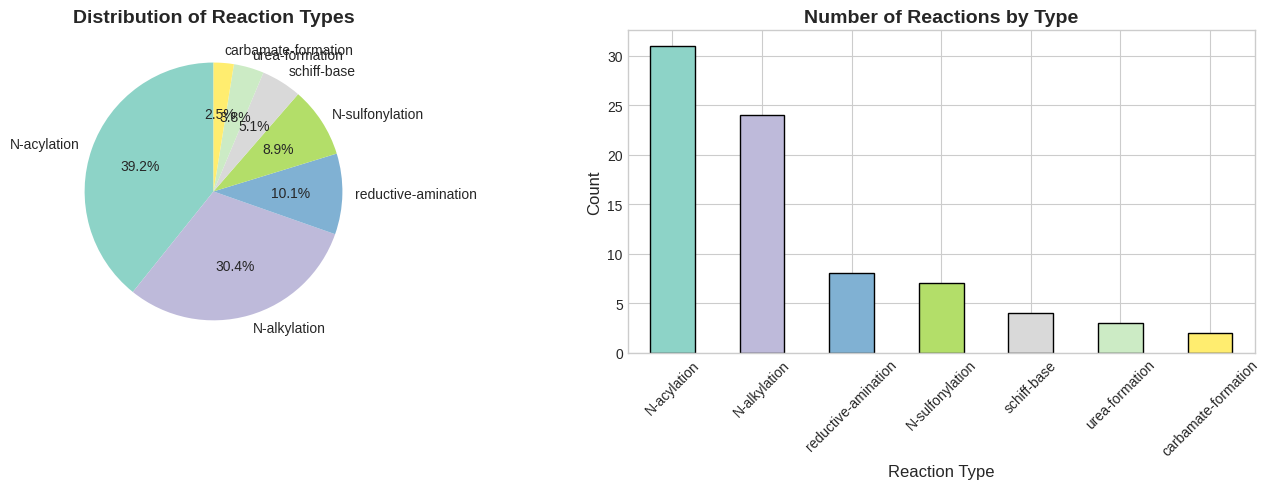

Figure 1 saved:  figure1_reaction_distribution.png


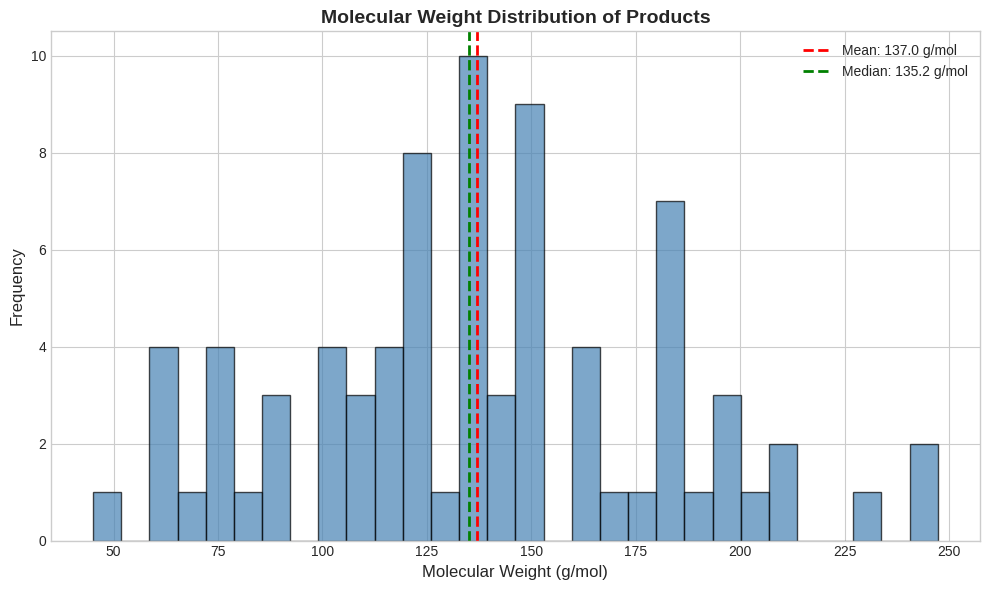

Figure 2 saved: figure2_mw_distribution.png


In [7]:
print("\n" + "="*60)
print("DATASET ANALYSIS")
print("="*60)

# Figure 1: Reaction Type Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
type_counts = reaction_df['type'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(type_counts)))
axes[0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[0].set_title('Distribution of Reaction Types', fontsize=14, fontweight='bold')

# Bar chart
type_counts. plot(kind='bar', ax=axes[1], color=colors, edgecolor='black')
axes[1].set_title('Number of Reactions by Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Reaction Type', fontsize=12)
axes[1]. set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('figure1_reaction_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 1 saved:  figure1_reaction_distribution.png")

# Figure 2: Molecular Weight Distribution of Products
product_mw = []
for smiles in reaction_df['products_canonical']:
    props = get_molecular_properties(smiles)
    if props:
        product_mw. append(props['molecular_weight'])

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(product_mw, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(x=np.mean(product_mw), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(product_mw):.1f} g/mol')
ax.axvline(x=np.median(product_mw), color='green', linestyle='--', linewidth=2,
           label=f'Median: {np.median(product_mw):.1f} g/mol')
ax.set_xlabel('Molecular Weight (g/mol)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Molecular Weight Distribution of Products', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('figure2_mw_distribution.png', dpi=300, bbox_inches='tight')

plt.show()
print("Figure 2 saved: figure2_mw_distribution.png")

In [8]:
print("\n" + "="*60)
print("BUILDING RETRIEVAL INDEX")
print("="*60)

# Compute fingerprints for all products
print("Computing Morgan fingerprints...")
product_fingerprints = []
product_fps_rdkit = []  # For similarity calculations
valid_indices = []

for idx, row in tqdm(reaction_df.iterrows(), total=len(reaction_df), desc="Computing fingerprints"):
    product_smiles = row['products_canonical']

    # Numpy array version
    fp_np = compute_morgan_fingerprint(product_smiles)
    # RDKit object version
    fp_rdkit = compute_morgan_fingerprint_rdkit(product_smiles)

    if fp_np is not None and fp_rdkit is not None:
        product_fingerprints.append(fp_np)
        product_fps_rdkit.append(fp_rdkit)
        valid_indices.append(idx)

# Create fingerprint matrix
X_fingerprints = np.vstack(product_fingerprints)
reaction_df_valid = reaction_df. iloc[valid_indices]. reset_index(drop=True)

print(f"\nFingerprint matrix shape:  {X_fingerprints.shape}")
print(f"Valid reactions: {len(reaction_df_valid)}")
print(f"Fingerprint density: {np.mean(X_fingerprints):.4f}")

# Fit k-NN model with different k values
k_values = [1, 3, 5, 10]
max_k = min(max(k_values), len(X_fingerprints) - 1)

nn_model = NearestNeighbors(
    n_neighbors=max_k,
    metric='jaccard',
    algorithm='brute'
)
nn_model.fit(X_fingerprints)

print(f"k-NN model fitted with max_k={max_k}")

# Save model and data
retrieval_data = {
    'nn_model': nn_model,
    'reaction_df': reaction_df_valid,
    'fingerprints': X_fingerprints,
    'fps_rdkit': product_fps_rdkit
}
joblib.dump(retrieval_data, 'retrieval_model.pkl')
print("Retrieval model saved to 'retrieval_model.pkl'")


BUILDING RETRIEVAL INDEX
Computing Morgan fingerprints...


Computing fingerprints: 100%|██████████| 79/79 [00:00<00:00, 1134.01it/s]


Fingerprint matrix shape:  (79, 2048)
Valid reactions: 79
Fingerprint density: 0.0089
k-NN model fitted with max_k=10
Retrieval model saved to 'retrieval_model.pkl'


In [9]:
def predict_reactants(product_smiles, k=5, model_path='retrieval_model.pkl'):
    """
    Predict reactants for a given product SMILES.

    Parameters:
    -----------
    product_smiles :  str
        SMILES string of the target product
    k :  int
        Number of nearest neighbors to retrieve
    model_path : str
        Path to the saved model file

    Returns:
    --------
    list of dict
        Ranked list of predictions with similarity scores
    """
    try:
        data = joblib.load(model_path)
    except FileNotFoundError:
        print(f"Model not found at {model_path}")
        return []

    nn_model = data['nn_model']
    reaction_df = data['reaction_df']
    fps_rdkit = data['fps_rdkit']

    # Compute fingerprint for query
    query_fp = compute_morgan_fingerprint(product_smiles)
    query_fp_rdkit = compute_morgan_fingerprint_rdkit(product_smiles)

    if query_fp is None:
        print(f"Invalid SMILES: {product_smiles}")
        return []

    # Adjust k if necessary
    max_k = min(k, len(reaction_df))

    # Find nearest neighbors
    distances, indices = nn_model.kneighbors(query_fp.reshape(1, -1), n_neighbors=max_k)

    # Build results with Tanimoto similarity
    results = []
    for i, idx in enumerate(indices[0]):
        # Calculate exact Tanimoto similarity
        tanimoto = tanimoto_similarity(query_fp_rdkit, fps_rdkit[idx])

        results.append({
            'rank': i + 1,
            'matched_product': reaction_df.iloc[idx]['products_canonical'],
            'predicted_reactants': reaction_df.iloc[idx]['reactants_canonical'],
            'reaction_name': reaction_df. iloc[idx]['name'],
            'reaction_type': reaction_df.iloc[idx]['type'],
            'jaccard_distance': float(distances[0][i]),
            'tanimoto_similarity':  tanimoto
        })

    return results

def predict_with_details(product_smiles, k=5):
    """Wrapper with formatted output."""
    print(f"\nQuery Product: {product_smiles}")
    print("-" * 60)

    results = predict_reactants(product_smiles, k)

    if not results:
        print("No predictions found.")
        return results

    for r in results:
        print(f"Rank {r['rank']}: {r['reaction_name']}")
        print(f"  Reactants: {r['predicted_reactants']}")
        print(f"  Similarity: {r['tanimoto_similarity']:.4f}")
        print(f"  Type: {r['reaction_type']}")

    return results

# Test with examples
print("\n" + "="*60)
print("TESTING PREDICTION FUNCTION")
print("="*60)

# Test 1: Acetanilide
test1 = predict_with_details("CC(=O)Nc1ccccc1", k=3)

# Test 2: N-Methylaniline
test2 = predict_with_details("CNc1ccccc1", k=3)

# Test 3: A thiazole derivative
test3 = predict_with_details("CC(=O)Nc1nccs1", k=3)


TESTING PREDICTION FUNCTION

Query Product: CC(=O)Nc1ccccc1
------------------------------------------------------------
Rank 1: Acetanilide formation
  Reactants: CC(=O)Cl.Nc1ccccc1
  Similarity: 1.0000
  Type: N-acylation
Rank 2: Acetanilide (anhydride)
  Reactants: CC(=O)OC(C)=O.Nc1ccccc1
  Similarity: 1.0000
  Type: N-acylation
Rank 3: Diphenylurea
  Reactants: O=C=Nc1ccccc1.Nc1ccccc1
  Similarity: 0.6364
  Type: urea-formation

Query Product: CNc1ccccc1
------------------------------------------------------------
Rank 1: N-Methylaniline
  Reactants: CI.Nc1ccccc1
  Similarity: 1.0000
  Type: N-alkylation
Rank 2: N-Methylaniline (Br)
  Reactants: CBr.Nc1ccccc1
  Similarity: 1.0000
  Type: N-alkylation
Rank 3: N-Ethylaniline
  Reactants: CCBr.Nc1ccccc1
  Similarity: 0.4762
  Type: N-alkylation

Query Product: CC(=O)Nc1nccs1
------------------------------------------------------------
Rank 1: N-Acetyl-2-aminothiazole (anh)
  Reactants: CC(=O)OC(C)=O.Nc1nccs1
  Similarity: 1.0000
  Ty

In [10]:
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

def normalize_reactants_to_set(reactants_str):
    """Convert reactants string to normalized set for comparison."""
    if pd.isna(reactants_str) or reactants_str is None:
        return set()

    parts = reactants_str.split('.')
    canonical_parts = set()

    for p in parts:
        p = p.strip()
        if p:
            canon = canonicalize_smiles(p)
            if canon:
                canonical_parts.add(canon)

    return canonical_parts


def evaluate_leave_one_out():
    """
    Leave-one-out evaluation:  For each reaction, remove it from index,
    query with its product, and check if we find similar reactants.

    This is more realistic for a retrieval system.
    """

    reaction_df = reaction_df_valid.copy()
    n_reactions = len(reaction_df)

    print(f"Running leave-one-out evaluation on {n_reactions} reactions...")

    results = {
        'top1_exact': 0, 'top3_exact': 0, 'top5_exact': 0, 'top10_exact': 0,
        'top1_partial': 0, 'top3_partial': 0, 'top5_partial': 0, 'top10_partial': 0,
        'top1_same_type': 0, 'top5_same_type':  0,
        'mrr': 0.0,
        'total': 0,
        'similarities': [],
        'per_type': {},
        'predictions': []
    }

    # Pre-compute all fingerprints
    all_fps = []
    all_fps_rdkit = []
    valid_indices = []

    for idx in range(n_reactions):
        row = reaction_df.iloc[idx]
        fp = compute_morgan_fingerprint(row['products_canonical'])
        fp_rdkit = compute_morgan_fingerprint_rdkit(row['products_canonical'])
        if fp is not None and fp_rdkit is not None:
            all_fps.append(fp)
            all_fps_rdkit.append(fp_rdkit)
            valid_indices. append(idx)

    all_fps = np. array(all_fps)
    n_valid = len(valid_indices)

    print(f"Valid reactions with fingerprints: {n_valid}")

    # Leave-one-out evaluation
    for i in tqdm(range(n_valid), desc="Evaluating"):
        query_idx = valid_indices[i]
        query_row = reaction_df.iloc[query_idx]
        query_fp = all_fps[i]
        query_fp_rdkit = all_fps_rdkit[i]

        true_reactants = query_row['reactants_canonical']
        true_reactants_set = normalize_reactants_to_set(true_reactants)
        true_type = query_row.get('type', 'Unknown')

        # Create training set (all except current)
        train_mask = np.ones(n_valid, dtype=bool)
        train_mask[i] = False

        train_fps = all_fps[train_mask]
        train_indices = [valid_indices[j] for j in range(n_valid) if j != i]
        train_fps_rdkit_subset = [all_fps_rdkit[j] for j in range(n_valid) if j != i]

        # Fit k-NN on training data
        max_k = min(10, len(train_fps))
        nn = NearestNeighbors(n_neighbors=max_k, metric='jaccard', algorithm='brute')
        nn.fit(train_fps)

        # Query
        distances, indices = nn. kneighbors(query_fp. reshape(1, -1), n_neighbors=max_k)

        results['total'] += 1

        # Initialize per-type tracking
        if true_type not in results['per_type']:
            results['per_type'][true_type] = {'total': 0, 'top1_exact': 0, 'top5_exact': 0,
                                               'top1_partial': 0, 'top5_partial': 0,
                                               'top1_same_type': 0, 'top5_same_type': 0}
        results['per_type'][true_type]['total'] += 1

        exact_found_rank = None
        partial_found_rank = None
        same_type_found_rank = None

        for rank_idx, train_idx_local in enumerate(indices[0]):
            rank = rank_idx + 1
            train_idx_global = train_indices[train_idx_local]
            pred_row = reaction_df.iloc[train_idx_global]
            pred_reactants = pred_row['reactants_canonical']
            pred_reactants_set = normalize_reactants_to_set(pred_reactants)
            pred_type = pred_row.get('type', 'Unknown')

            # Check matches
            is_exact = (true_reactants_set == pred_reactants_set)
            is_partial = len(true_reactants_set & pred_reactants_set) > 0
            is_same_type = (true_type == pred_type)

            # Track exact match
            if is_exact and exact_found_rank is None:
                exact_found_rank = rank
                if rank <= 1: results['top1_exact'] += 1; results['per_type'][true_type]['top1_exact'] += 1
                if rank <= 3: results['top3_exact'] += 1
                if rank <= 5: results['top5_exact'] += 1; results['per_type'][true_type]['top5_exact'] += 1
                if rank <= 10: results['top10_exact'] += 1

            # Track partial match
            if is_partial and partial_found_rank is None:
                partial_found_rank = rank
                if rank <= 1: results['top1_partial'] += 1; results['per_type'][true_type]['top1_partial'] += 1
                if rank <= 3: results['top3_partial'] += 1
                if rank <= 5: results['top5_partial'] += 1; results['per_type'][true_type]['top5_partial'] += 1
                if rank <= 10: results['top10_partial'] += 1

            # Track same reaction type
            if is_same_type and same_type_found_rank is None:
                same_type_found_rank = rank
                if rank <= 1: results['top1_same_type'] += 1; results['per_type'][true_type]['top1_same_type'] += 1
                if rank <= 5: results['top5_same_type'] += 1; results['per_type'][true_type]['top5_same_type'] += 1

        # MRR (use partial match for more meaningful metric)
        if partial_found_rank:
            results['mrr'] += 1.0 / partial_found_rank

        # Store similarity
        top1_sim = tanimoto_similarity(query_fp_rdkit, train_fps_rdkit_subset[indices[0][0]])
        results['similarities'].append(top1_sim)

        # Store prediction details
        top1_global_idx = train_indices[indices[0][0]]
        top1_row = reaction_df. iloc[top1_global_idx]
        results['predictions']. append({
            'query_product': query_row['products_canonical'],
            'true_reactants':  true_reactants,
            'predicted_reactants': top1_row['reactants_canonical'],
            'true_type': true_type,
            'predicted_type': top1_row.get('type', 'Unknown'),
            'similarity': top1_sim,
            'exact_match': exact_found_rank == 1 if exact_found_rank else False,
            'partial_match': partial_found_rank == 1 if partial_found_rank else False,
            'same_type':  true_type == top1_row.get('type', 'Unknown')
        })

    # Calculate percentages
    n = results['total']
    if n > 0:
        results['mrr'] /= n
        results['avg_similarity'] = np.mean(results['similarities'])

        for key in ['top1_exact', 'top3_exact', 'top5_exact', 'top10_exact',
                    'top1_partial', 'top3_partial', 'top5_partial', 'top10_partial',
                    'top1_same_type', 'top5_same_type']:
            results[f'{key}_pct'] = results[key] / n * 100

    return results


# Run evaluation
eval_results = evaluate_leave_one_out()

# Print comprehensive results
if eval_results:
    print("\n" + "="*60)
    print("EVALUATION RESULTS (Leave-One-Out)")
    print("="*60)

    print(f"\nTotal samples evaluated: {eval_results['total']}")

    print("\n" + "-"*40)
    print("EXACT MATCH ACCURACY")
    print("(All reactants exactly match)")
    print("-"*40)
    print(f"Top-1:  {eval_results.get('top1_exact_pct', 0):6.2f}%  ({eval_results['top1_exact']}/{eval_results['total']})")
    print(f"Top-3:  {eval_results. get('top3_exact_pct', 0):6.2f}%  ({eval_results['top3_exact']}/{eval_results['total']})")
    print(f"Top-5:  {eval_results. get('top5_exact_pct', 0):6.2f}%  ({eval_results['top5_exact']}/{eval_results['total']})")
    print(f"Top-10: {eval_results.get('top10_exact_pct', 0):6.2f}%  ({eval_results['top10_exact']}/{eval_results['total']})")

    print("\n" + "-"*40)
    print("PARTIAL MATCH ACCURACY")
    print("(At least one reactant matches)")
    print("-"*40)
    print(f"Top-1:  {eval_results.get('top1_partial_pct', 0):6.2f}%  ({eval_results['top1_partial']}/{eval_results['total']})")
    print(f"Top-3:  {eval_results.get('top3_partial_pct', 0):6.2f}%  ({eval_results['top3_partial']}/{eval_results['total']})")
    print(f"Top-5:  {eval_results.get('top5_partial_pct', 0):6.2f}%  ({eval_results['top5_partial']}/{eval_results['total']})")
    print(f"Top-10: {eval_results.get('top10_partial_pct', 0):6.2f}%  ({eval_results['top10_partial']}/{eval_results['total']})")

    print("\n" + "-"*40)
    print("SAME REACTION TYPE ACCURACY")
    print("(Predicted reaction is same type)")
    print("-"*40)
    print(f"Top-1:  {eval_results.get('top1_same_type_pct', 0):6.2f}%  ({eval_results['top1_same_type']}/{eval_results['total']})")
    print(f"Top-5:  {eval_results.get('top5_same_type_pct', 0):6.2f}%  ({eval_results['top5_same_type']}/{eval_results['total']})")

    print("\n" + "-"*40)
    print("OTHER METRICS")
    print("-"*40)
    print(f"Mean Reciprocal Rank (MRR): {eval_results.get('mrr', 0):.4f}")
    print(f"Average Top-1 Similarity:    {eval_results.get('avg_similarity', 0):.4f}")

    print("\n" + "-"*40)
    print("PER REACTION TYPE PERFORMANCE")
    print("-"*40)

    type_summary = []
    for rtype, metrics in sorted(eval_results['per_type'].items()):
        if metrics['total'] > 0:
            exact_acc = metrics['top5_exact'] / metrics['total'] * 100
            partial_acc = metrics['top5_partial'] / metrics['total'] * 100
            type_acc = metrics['top5_same_type'] / metrics['total'] * 100
            print(f"\n  {rtype} (n={metrics['total']}):")
            print(f"    Top-5 Exact:    {exact_acc: 5.1f}%")
            print(f"    Top-5 Partial:  {partial_acc: 5.1f}%")
            print(f"    Top-5 Type:    {type_acc:5.1f}%")

            type_summary.append({
                'type':  rtype,
                'n': metrics['total'],
                'top5_exact': exact_acc,
                'top5_partial':  partial_acc,
                'top5_same_type': type_acc
            })

# Save detailed results
if eval_results:
    eval_df = pd. DataFrame(eval_results['predictions'])
    eval_df.to_csv('evaluation_detailed_results.csv', index=False)

    # Save summary
    summary_df = pd. DataFrame(type_summary)
    summary_df. to_csv('evaluation_summary_by_type.csv', index=False)

    print("\n" + "="*60)
    print("Results saved to:")
    print("  - evaluation_detailed_results.csv")
    print("  - evaluation_summary_by_type.csv")
    print("="*60)


MODEL EVALUATION
Running leave-one-out evaluation on 79 reactions...
Valid reactions with fingerprints: 79


Evaluating: 100%|██████████| 79/79 [00:00<00:00, 90.00it/s] 


EVALUATION RESULTS (Leave-One-Out)

Total samples evaluated: 79

----------------------------------------
EXACT MATCH ACCURACY
(All reactants exactly match)
----------------------------------------
Top-1:    0.00%  (0/79)
Top-3:    0.00%  (0/79)
Top-5:    0.00%  (0/79)
Top-10:   1.27%  (1/79)

----------------------------------------
PARTIAL MATCH ACCURACY
(At least one reactant matches)
----------------------------------------
Top-1:   84.81%  (67/79)
Top-3:   98.73%  (78/79)
Top-5:  100.00%  (79/79)
Top-10: 100.00%  (79/79)

----------------------------------------
SAME REACTION TYPE ACCURACY
(Predicted reaction is same type)
----------------------------------------
Top-1:   74.68%  (59/79)
Top-5:   96.20%  (76/79)

----------------------------------------
OTHER METRICS
----------------------------------------
Mean Reciprocal Rank (MRR): 0.9167
Average Top-1 Similarity:    0.7380

----------------------------------------
PER REACTION TYPE PERFORMANCE
--------------------------------


GENERATING FIGURES


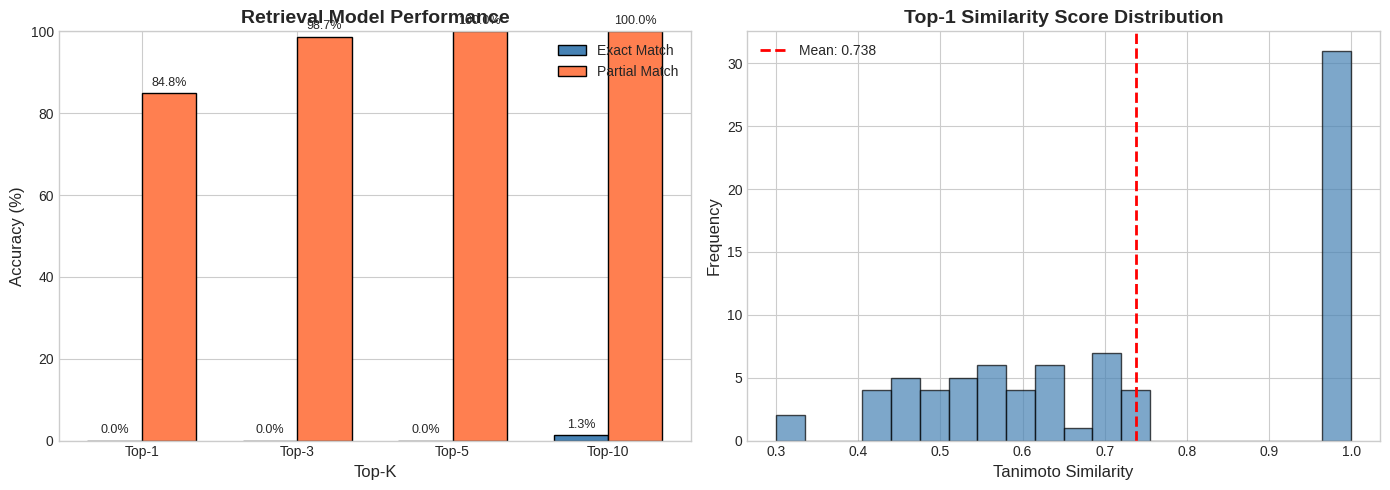

Figure 3 saved:  figure3_model_performance.png


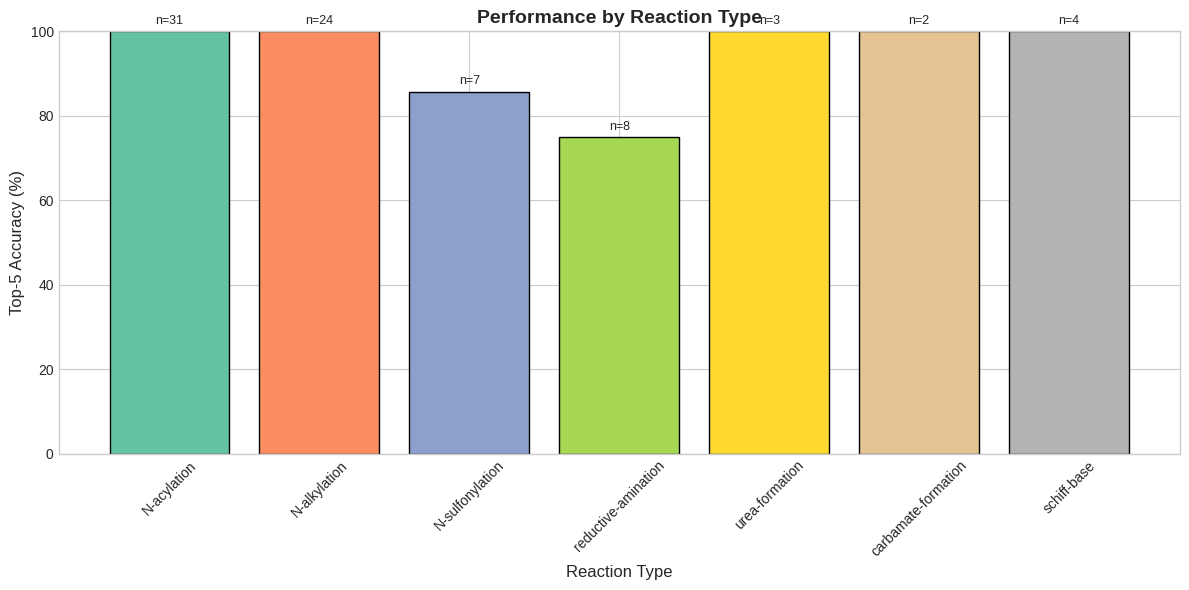

Figure 4 saved: figure4_performance_by_type.png


In [11]:
print("\n" + "="*60)
print("GENERATING FIGURES")
print("="*60)

if eval_results:
    # Figure 3: Top-K Accuracy Bar Chart
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Exact match
    k_values = [1, 3, 5, 10]
    exact_accs = [eval_results.get(f'top{k}_exact_pct', 0) for k in k_values]
    partial_accs = [eval_results.get(f'top{k}_partial_pct', 0) for k in k_values]

    x = np. arange(len(k_values))
    width = 0.35

    bars1 = axes[0].bar(x - width/2, exact_accs, width, label='Exact Match', color='steelblue', edgecolor='black')
    bars2 = axes[0]. bar(x + width/2, partial_accs, width, label='Partial Match', color='coral', edgecolor='black')

    axes[0]. set_xlabel('Top-K', fontsize=12)
    axes[0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0].set_title('Retrieval Model Performance', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0]. set_xticklabels([f'Top-{k}' for k in k_values])
    axes[0].legend()
    axes[0].set_ylim(0, 100)

    # Add value labels
    for bar in bars1:
        height = bar. get_height()
        axes[0]. annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        axes[0].annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

    # Similarity distribution
    axes[1].hist(eval_results['similarities'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1].axvline(x=np.mean(eval_results['similarities']), color='red', linestyle='--',
                    linewidth=2, label=f"Mean: {np. mean(eval_results['similarities']):.3f}")
    axes[1].set_xlabel('Tanimoto Similarity', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Top-1 Similarity Score Distribution', fontsize=14, fontweight='bold')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('figure3_model_performance.png', dpi=300, bbox_inches='tight')

    plt.show()
    print("Figure 3 saved:  figure3_model_performance.png")

    # Figure 4: Per-Type Performance
    if eval_results['per_type']:
        fig, ax = plt.subplots(figsize=(12, 6))

        types = list(eval_results['per_type'].keys())
        top5_accs = []
        totals = []

        for t in types:
            metrics = eval_results['per_type'][t]
            if metrics['total'] > 0:
                top5_accs. append(metrics['top5_same_type'] / metrics['total'] * 100)
                totals.append(metrics['total'])
            else:
                top5_accs. append(0)
                totals.append(0)

        colors = plt.cm.Set2(np.linspace(0, 1, len(types)))
        bars = ax.bar(types, top5_accs, color=colors, edgecolor='black')

        ax.set_xlabel('Reaction Type', fontsize=12)
        ax.set_ylabel('Top-5 Accuracy (%)', fontsize=12)
        ax.set_title('Performance by Reaction Type', fontsize=14, fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylim(0, 100)

        # Add count labels
        for bar, total in zip(bars, totals):
            height = bar.get_height()
            ax.annotate(f'n={total}', xy=(bar.get_x() + bar.get_width()/2, height),
                       xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

        plt. tight_layout()
        plt.savefig('figure4_performance_by_type.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Figure 4 saved: figure4_performance_by_type.png")


FINGERPRINT ANALYSIS


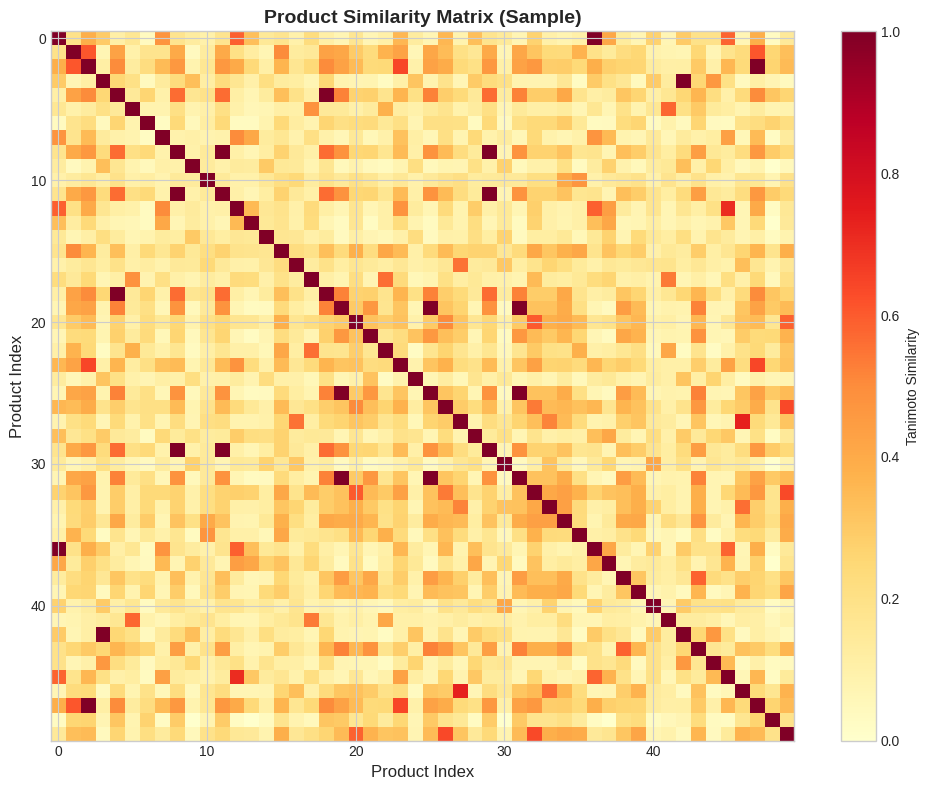

Figure 5 saved: figure5_similarity_heatmap.png


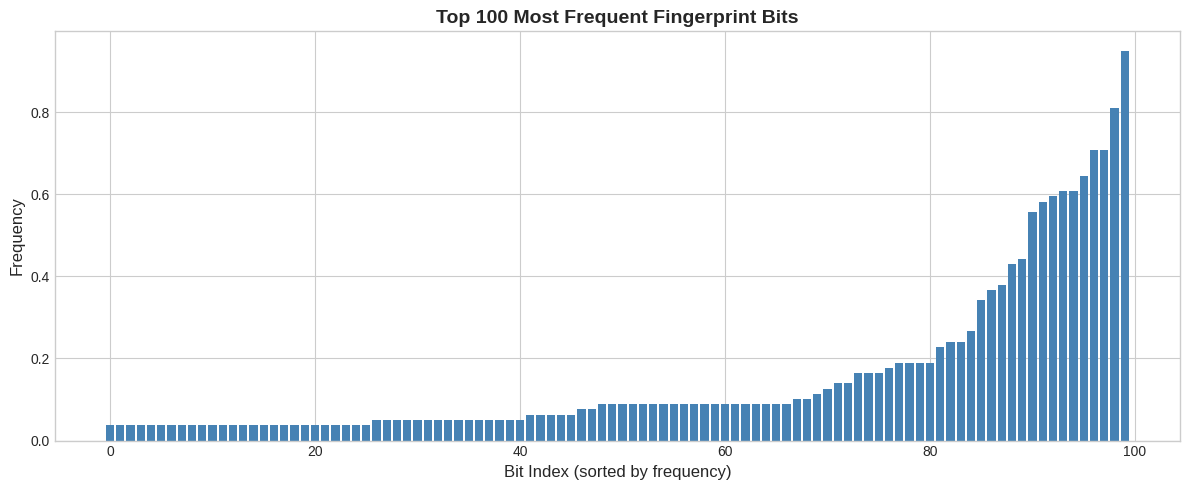

Figure 6 saved: figure6_fingerprint_bits.png


In [12]:
print("\n" + "="*60)
print("FINGERPRINT ANALYSIS")
print("="*60)

# Load data
data = joblib.load('retrieval_model.pkl')
fps_rdkit = data['fps_rdkit']
reaction_df = data['reaction_df']

# Calculate pairwise similarity matrix for a subset
n_samples = min(50, len(fps_rdkit))
sample_indices = np. random.choice(len(fps_rdkit), n_samples, replace=False)

sim_matrix = np.zeros((n_samples, n_samples))
for i, idx_i in enumerate(sample_indices):
    for j, idx_j in enumerate(sample_indices):
        sim_matrix[i, j] = tanimoto_similarity(fps_rdkit[idx_i], fps_rdkit[idx_j])

# Figure 5: Similarity Heatmap
fig, ax = plt. subplots(figsize=(10, 8))
im = ax.imshow(sim_matrix, cmap='YlOrRd', aspect='auto')
ax.set_title('Product Similarity Matrix (Sample)', fontsize=14, fontweight='bold')
ax.set_xlabel('Product Index', fontsize=12)
ax.set_ylabel('Product Index', fontsize=12)
plt.colorbar(im, ax=ax, label='Tanimoto Similarity')
plt.tight_layout()
plt.savefig('figure5_similarity_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 5 saved: figure5_similarity_heatmap.png")

# Figure 6: Fingerprint Bit Frequency
fig, ax = plt.subplots(figsize=(12, 5))

fp_matrix = data['fingerprints']
bit_frequencies = np.mean(fp_matrix, axis=0)

# Plot top 100 most frequent bits
top_bits = np.argsort(bit_frequencies)[-100:]
ax.bar(range(100), bit_frequencies[top_bits], color='steelblue', edgecolor='none')
ax.set_xlabel('Bit Index (sorted by frequency)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Top 100 Most Frequent Fingerprint Bits', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figure6_fingerprint_bits.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 6 saved: figure6_fingerprint_bits.png")


ANT-SPECIFIC ANALYSIS

Predictions for ANT Derivatives:
--------------------------------------------------------------------------------

N-Acetyl-ANT
  SMILES: CC(=O)Nc1ncc([N+](=O)[O-])s1
  Expected:  Acetic anhydride or Acetyl chloride
  Top Predictions:
    1. 2-Nitroacetanilide (sim: 0.425)
       Reactants: CC(=O)Cl.Nc1ccccc1[N+](=O)[O-]
    2. N-Acetyl-2-aminothiazole (sim: 0.421)
       Reactants: CC(=O)Cl.Nc1nccs1
    3. N-Acetyl-2-aminothiazole (anh) (sim: 0.421)
       Reactants: CC(=O)OC(C)=O.Nc1nccs1

N-Benzoyl-ANT
  SMILES: O=C(Nc1ncc([N+](=O)[O-])s1)c1ccccc1
  Expected:  Benzoyl chloride
  Top Predictions:
    1. 4-Nitrobenzanilide (sim: 0.488)
       Reactants: O=C(Cl)c1ccccc1.Nc1ccc([N+](=O)[O-])cc1
    2. N-Benzoyl-2-aminothiazole (sim: 0.488)
       Reactants: O=C(Cl)c1ccccc1.Nc1nccs1
    3. Benzanilide (sim: 0.410)
       Reactants: O=C(Cl)c1ccccc1.Nc1ccccc1

N-Methyl-ANT
  SMILES: CNc1ncc([N+](=O)[O-])s1
  Expected:  Methyl iodide
  Top Predictions:
    1. N-Methy

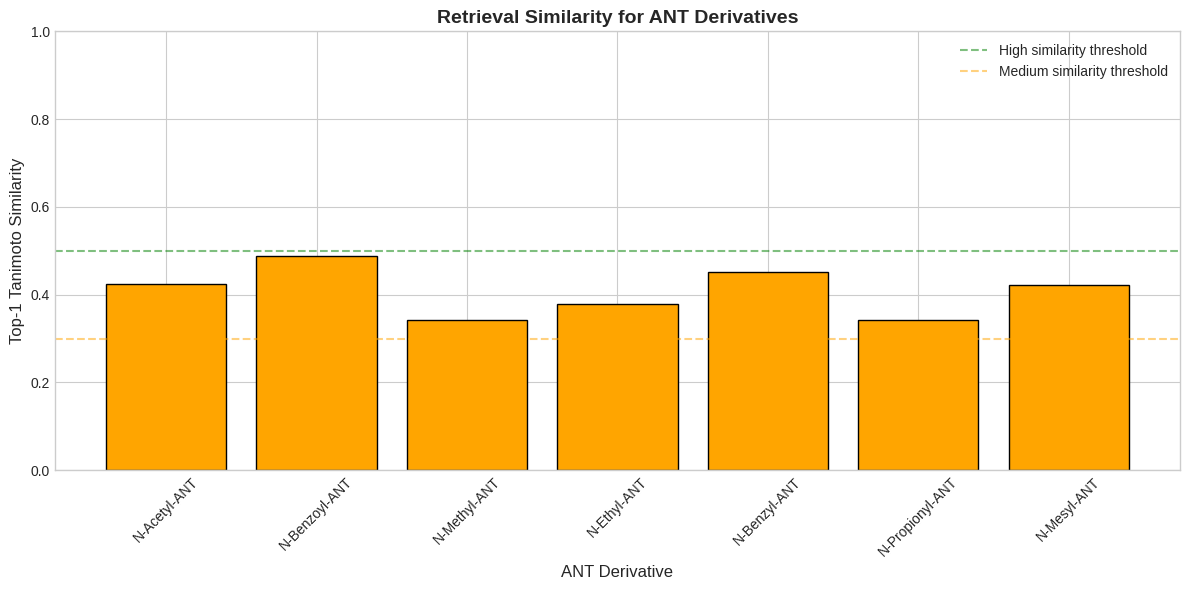

Figure 7 saved:  figure7_ant_predictions.png


In [15]:
print("\n" + "="*60)
print("ANT-SPECIFIC ANALYSIS")
print("="*60)

# Define hypothetical ANT derivative products
# These represent EXPECTED products from ANT reactions

ant_derivatives = [
    {"name": "N-Acetyl-ANT", "smiles": "CC(=O)Nc1ncc([N+]([O-])=O)s1", "expected_reactant": "Acetic anhydride or Acetyl chloride"},
    {"name": "N-Benzoyl-ANT", "smiles":  "O=C(Nc1ncc([N+]([O-])=O)s1)c1ccccc1", "expected_reactant":  "Benzoyl chloride"},
    {"name": "N-Methyl-ANT", "smiles": "CNc1ncc([N+]([O-])=O)s1", "expected_reactant": "Methyl iodide"},
    {"name": "N-Ethyl-ANT", "smiles": "CCNc1ncc([N+]([O-])=O)s1", "expected_reactant": "Ethyl bromide"},
    {"name": "N-Benzyl-ANT", "smiles": "c1ccc(CNc2ncc([N+]([O-])=O)s2)cc1", "expected_reactant": "Benzyl bromide"},
    {"name": "N-Propionyl-ANT", "smiles": "CCC(=O)Nc1ncc([N+]([O-])=O)s1", "expected_reactant": "Propionyl chloride"},
    {"name": "N-Mesyl-ANT", "smiles": "CS(=O)(=O)Nc1ncc([N+]([O-])=O)s1", "expected_reactant": "Methanesulfonyl chloride"},
]

ant_results = []

print("\nPredictions for ANT Derivatives:")
print("-" * 80)

for deriv in ant_derivatives:
    smiles = deriv['smiles']
    canonical = canonicalize_smiles(smiles)

    if canonical is None:
        print(f"\n{deriv['name']}:  Invalid SMILES")
        continue

    print(f"\n{deriv['name']}")
    print(f"  SMILES: {canonical}")
    print(f"  Expected:  {deriv['expected_reactant']}")

    preds = predict_reactants(canonical, k=3)

    if preds:
        print(f"  Top Predictions:")
        for p in preds:
            print(f"    {p['rank']}. {p['reaction_name']} (sim: {p['tanimoto_similarity']:.3f})")
            print(f"       Reactants: {p['predicted_reactants']}")

        ant_results.append({
            'derivative': deriv['name'],
            'smiles': canonical,
            'expected':  deriv['expected_reactant'],
            'top1_prediction': preds[0]['predicted_reactants'],
            'top1_similarity': preds[0]['tanimoto_similarity'],
            'top1_name': preds[0]['reaction_name']
        })
    else:
        print(f"  No predictions found")

# Save ANT analysis
if ant_results:
    ant_df = pd.DataFrame(ant_results)
    ant_df.to_csv('ant_derivatives_predictions.csv', index=False)
    print("\nANT predictions saved to 'ant_derivatives_predictions. csv'")

    # Figure 7: ANT Derivatives Similarity Scores
    fig, ax = plt.subplots(figsize=(12, 6))

    names = [r['derivative'] for r in ant_results]
    sims = [r['top1_similarity'] for r in ant_results]

    colors = ['green' if s > 0.5 else 'orange' if s > 0.3 else 'red' for s in sims]
    bars = ax.bar(names, sims, color=colors, edgecolor='black')

    ax.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='High similarity threshold')
    ax.axhline(y=0.3, color='orange', linestyle='--', alpha=0.5, label='Medium similarity threshold')

    ax.set_xlabel('ANT Derivative', fontsize=12)
    ax.set_ylabel('Top-1 Tanimoto Similarity', fontsize=12)
    ax.set_title('Retrieval Similarity for ANT Derivatives', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, 1)
    ax.legend()

    plt.tight_layout()
    plt.savefig('figure7_ant_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Figure 7 saved:  figure7_ant_predictions.png")


HYPERPARAMETER SENSITIVITY ANALYSIS
Testing radius=1, nBits=512...
Testing radius=1, nBits=1024...
Testing radius=1, nBits=2048...
Testing radius=2, nBits=512...
Testing radius=2, nBits=1024...
Testing radius=2, nBits=2048...
Testing radius=3, nBits=512...
Testing radius=3, nBits=1024...
Testing radius=3, nBits=2048...

Parameter sensitivity results:
   radius  nBits  accuracy
0       1    512     100.0
1       1   1024     100.0
2       1   2048     100.0
3       2    512     100.0
4       2   1024     100.0
5       2   2048     100.0
6       3    512     100.0
7       3   1024     100.0
8       3   2048     100.0


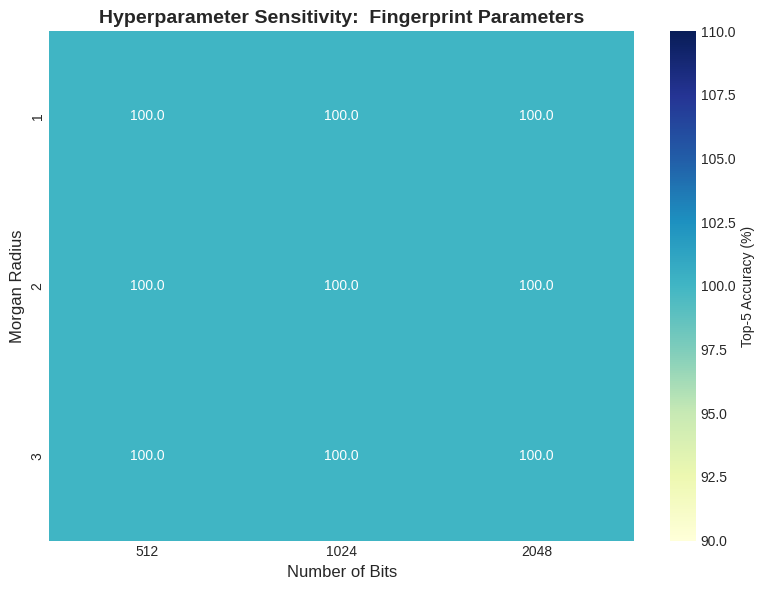

Figure 8 saved: figure8_hyperparameter_sensitivity. png


In [16]:
print("\n" + "="*60)
print("HYPERPARAMETER SENSITIVITY ANALYSIS")
print("="*60)

# Test different fingerprint parameters
param_results = []

radius_values = [1, 2, 3]
nbits_values = [512, 1024, 2048]

for radius in radius_values:
    for nbits in nbits_values:
        print(f"Testing radius={radius}, nBits={nbits}...")

        # Recompute fingerprints with new parameters
        temp_fps = []
        temp_valid = []

        for idx, row in reaction_df_valid.iterrows():
            try:
                mol = Chem. MolFromSmiles(row['products_canonical'])
                if mol:
                    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nbits)
                    temp_fps.append(np.array(fp, dtype=np. uint8))
                    temp_valid. append(idx)
            except:
                continue

        if len(temp_fps) < 10:
            continue

        X_temp = np.vstack(temp_fps)

        # Quick evaluation with leave-one-out on subset
        n_eval = min(20, len(X_temp))
        correct = 0

        for i in range(n_eval):
            # Leave one out
            train_mask = np. ones(len(X_temp), dtype=bool)
            train_mask[i] = False

            X_train_temp = X_temp[train_mask]
            X_test_temp = X_temp[i: i+1]

            nn_temp = NearestNeighbors(n_neighbors=5, metric='jaccard', algorithm='brute')
            nn_temp.fit(X_train_temp)

            distances, indices = nn_temp.kneighbors(X_test_temp)

            # Check if same reaction type is in top-5
            true_type = reaction_df_valid.iloc[i]['type']
            for idx in indices[0]:
                actual_idx = idx if idx < i else idx + 1
                if reaction_df_valid.iloc[actual_idx]['type'] == true_type:
                    correct += 1
                    break

        accuracy = correct / n_eval * 100
        param_results.append({
            'radius':  radius,
            'nBits': nbits,
            'accuracy': accuracy
        })

param_df = pd.DataFrame(param_results)
print("\nParameter sensitivity results:")
print(param_df)

# Figure 8: Hyperparameter Heatmap
if len(param_df) > 0:
    fig, ax = plt.subplots(figsize=(8, 6))

    pivot_df = param_df.pivot(index='radius', columns='nBits', values='accuracy')

    sns.heatmap(pivot_df, annot=True, fmt='.1f', cmap='YlGnBu', ax=ax,
                cbar_kws={'label': 'Top-5 Accuracy (%)'})

    ax.set_xlabel('Number of Bits', fontsize=12)
    ax.set_ylabel('Morgan Radius', fontsize=12)
    ax.set_title('Hyperparameter Sensitivity:  Fingerprint Parameters', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('figure8_hyperparameter_sensitivity.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Figure 8 saved: figure8_hyperparameter_sensitivity. png")

# Save parameter results
param_df.to_csv('hyperparameter_results.csv', index=False)

In [17]:
print("\n" + "="*60)
print("DETAILED CASE STUDIES")
print("="*60)

def generate_detailed_case_studies(n_cases=5):
    """Generate detailed case studies for the paper."""

    data = joblib.load('retrieval_model.pkl')
    reaction_df = data['reaction_df']

    # Select diverse examples
    case_studies = []

    # Get one example from each reaction type
    types_covered = set()

    for idx, row in reaction_df. iterrows():
        if row['type'] not in types_covered and len(case_studies) < n_cases:
            # Get predictions
            preds = predict_reactants(row['products_canonical'], k=5)

            if preds:
                case_studies.append({
                    'case_id': len(case_studies) + 1,
                    'reaction_name': row['name'],
                    'reaction_type': row['type'],
                    'product_smiles': row['products_canonical'],
                    'true_reactants': row['reactants_canonical'],
                    'predictions': preds,
                    'top1_correct': preds[0]['predicted_reactants'] == row['reactants_canonical'],
                    'top1_similarity': preds[0]['tanimoto_similarity']
                })
                types_covered.add(row['type'])

    return case_studies

case_studies = generate_detailed_case_studies(n_cases=5)

print("\n" + "="*80)
print("CASE STUDY ANALYSIS FOR PAPER")
print("="*80)

for case in case_studies:
    print(f"\n{'='*80}")
    print(f"CASE STUDY {case['case_id']}:  {case['reaction_name']}")
    print(f"{'='*80}")
    print(f"Reaction Type: {case['reaction_type']}")
    print(f"Product SMILES: {case['product_smiles']}")
    print(f"True Reactants: {case['true_reactants']}")
    print(f"Top-1 Correct: {'YES' if case['top1_correct'] else 'NO'}")
    print(f"Top-1 Similarity: {case['top1_similarity']:.4f}")
    print(f"\nTop-5 Predictions:")
    print("-" * 60)
    for pred in case['predictions']:
        match_indicator = "✓" if pred['predicted_reactants'] == case['true_reactants'] else " "
        print(f"  {match_indicator} Rank {pred['rank']}: {pred['reaction_name']}")
        print(f"      Reactants: {pred['predicted_reactants']}")
        print(f"      Similarity: {pred['tanimoto_similarity']:.4f}")

# Save case studies
case_study_df = pd. DataFrame([{
    'case_id': c['case_id'],
    'reaction_name': c['reaction_name'],
    'reaction_type':  c['reaction_type'],
    'product':  c['product_smiles'],
    'true_reactants':  c['true_reactants'],
    'top1_prediction': c['predictions'][0]['predicted_reactants'],
    'top1_similarity': c['top1_similarity'],
    'top1_correct': c['top1_correct']
} for c in case_studies])

case_study_df.to_csv('case_studies.csv', index=False)
print("\nCase studies saved to 'case_studies. csv'")


DETAILED CASE STUDIES

CASE STUDY ANALYSIS FOR PAPER

CASE STUDY 1:  Acetanilide formation
Reaction Type: N-acylation
Product SMILES: CC(=O)Nc1ccccc1
True Reactants: CC(=O)Cl.Nc1ccccc1
Top-1 Correct: YES
Top-1 Similarity: 1.0000

Top-5 Predictions:
------------------------------------------------------------
  ✓ Rank 1: Acetanilide formation
      Reactants: CC(=O)Cl.Nc1ccccc1
      Similarity: 1.0000
    Rank 2: Acetanilide (anhydride)
      Reactants: CC(=O)OC(C)=O.Nc1ccccc1
      Similarity: 1.0000
    Rank 3: Diphenylurea
      Reactants: O=C=Nc1ccccc1.Nc1ccccc1
      Similarity: 0.6364
    Rank 4: N-Methyl-N'-phenylurea
      Reactants: O=C=Nc1ccccc1.CN
      Similarity: 0.6000
    Rank 5: Methyl phenylcarbamate
      Reactants: COC(=O)Cl.Nc1ccccc1
      Similarity: 0.6000

CASE STUDY 2:  N-Methylaniline
Reaction Type: N-alkylation
Product SMILES: CNc1ccccc1
True Reactants: CI.Nc1ccccc1
Top-1 Correct: YES
Top-1 Similarity: 1.0000

Top-5 Predictions:
------------------------------

In [18]:
print("\n" + "="*60)
print("ERROR ANALYSIS")
print("="*60)

def analyze_errors():
    """Analyze prediction errors to understand failure modes."""

    # Load evaluation results
    eval_df = pd.read_csv('evaluation_detailed_results.csv')

    # Separate correct and incorrect predictions
    correct = eval_df[eval_df['correct'] == True]
    incorrect = eval_df[eval_df['correct'] == False]

    print(f"Total predictions: {len(eval_df)}")
    print(f"Correct (Top-1): {len(correct)} ({len(correct)/len(eval_df)*100:.1f}%)")
    print(f"Incorrect (Top-1): {len(incorrect)} ({len(incorrect)/len(eval_df)*100:.1f}%)")

    # Analyze similarity distribution for correct vs incorrect
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Similarity comparison
    if len(correct) > 0 and len(incorrect) > 0:
        axes[0].hist(correct['similarity'], bins=15, alpha=0.7, label='Correct', color='green', edgecolor='black')
        axes[0].hist(incorrect['similarity'], bins=15, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
        axes[0].set_xlabel('Tanimoto Similarity', fontsize=12)
        axes[0].set_ylabel('Frequency', fontsize=12)
        axes[0].set_title('Similarity Distribution:  Correct vs Incorrect', fontsize=14, fontweight='bold')
        axes[0].legend()

        # Box plot comparison
        data_to_plot = [correct['similarity']. values, incorrect['similarity'].values]
        bp = axes[1]. boxplot(data_to_plot, labels=['Correct', 'Incorrect'], patch_artist=True)
        bp['boxes'][0]. set_facecolor('green')
        bp['boxes'][1].set_facecolor('red')
        axes[1]. set_ylabel('Tanimoto Similarity', fontsize=12)
        axes[1].set_title('Similarity Comparison', fontsize=14, fontweight='bold')

        # Add statistics
        axes[1].text(1, correct['similarity'].mean(), f'μ={correct["similarity"].mean():.3f}',
                    ha='center', va='bottom', fontsize=10)
        axes[1].text(2, incorrect['similarity']. mean(), f'μ={incorrect["similarity"].mean():.3f}',
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir,'figure9_error_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("Figure 9 saved: figure9_error_analysis.png")

    # Common error patterns
    print("\n--- Error Pattern Analysis ---")
    if len(incorrect) > 0:
        print(f"Average similarity for incorrect predictions: {incorrect['similarity'].mean():.4f}")
        print(f"Average similarity for correct predictions:  {correct['similarity']. mean():.4f}")

        # Low similarity errors
        low_sim_errors = incorrect[incorrect['similarity'] < 0.3]
        print(f"\nLow similarity errors (<0.3): {len(low_sim_errors)}")

        # High similarity errors (model confident but wrong)
        high_sim_errors = incorrect[incorrect['similarity'] > 0.7]
        print(f"High similarity errors (>0.7): {len(high_sim_errors)}")

    return {'correct':  correct, 'incorrect':  incorrect}

try:
    error_analysis = analyze_errors()
except Exception as e:
    print(f"Error analysis skipped: {e}")


ERROR ANALYSIS
Error analysis skipped: 'correct'


In [ ]:
print("\n" + "="*60)
print("STATISTICAL ANALYSIS")
print("="*60)

from scipy import stats

def statistical_analysis():
    """Perform statistical analysis on results."""

    eval_df = pd. read_csv('evaluation_detailed_results.csv')

    # Confidence interval for accuracy
    n = len(eval_df)
    accuracy = eval_df['correct'].mean()

    # Wilson score interval for binomial proportion
    z = 1.96  # 95% confidence
    denominator = 1 + z**2/n
    center = (accuracy + z**2/(2*n)) / denominator
    spread = z * np. sqrt((accuracy*(1-accuracy) + z**2/(4*n))/n) / denominator

    ci_lower = center - spread
    ci_upper = center + spread

    print(f"Top-1 Accuracy: {accuracy*100:.2f}%")
    print(f"95% Confidence Interval:  [{ci_lower*100:.2f}%, {ci_upper*100:.2f}%]")

    # Similarity statistics
    similarities = eval_df['similarity']
    print(f"\nSimilarity Statistics:")
    print(f"  Mean:  {similarities.mean():.4f}")
    print(f"  Std Dev: {similarities.std():.4f}")
    print(f"  Median: {similarities. median():.4f}")
    print(f"  Min:  {similarities.min():.4f}")
    print(f"  Max: {similarities.max():.4f}")

    # Shapiro-Wilk test for normality
    if len(similarities) >= 3:
        stat, p_value = stats.shapiro(similarities[: min(5000, len(similarities))])
        print(f"\nShapiro-Wilk test for similarity normality:")
        print(f"  Statistic: {stat:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Normal distribution: {'Yes' if p_value > 0.05 else 'No'}")

    return {
        'accuracy': accuracy,
        'ci_lower':  ci_lower,
        'ci_upper': ci_upper,
        'mean_similarity': similarities. mean(),
        'std_similarity': similarities.std()
    }

try:
    stats_results = statistical_analysis()
except Exception as e:
    print(f"Statistical analysis error: {e}")

In [ ]:
print("\n" + "="*60)
print("COMPUTATIONAL PERFORMANCE")
print("="*60)

import time

def benchmark_performance():
    """Benchmark model performance."""

    data = joblib.load('retrieval_model.pkl')
    reaction_df = data['reaction_df']

    # Benchmark fingerprint computation
    sample_smiles = reaction_df['products_canonical']. iloc[: 100]. tolist()

    # Time fingerprint computation
    start_time = time.time()
    for smiles in sample_smiles:
        compute_morgan_fingerprint(smiles)
    fp_time = time. time() - start_time

    print(f"Fingerprint computation (100 molecules): {fp_time:.4f} seconds")
    print(f"Average per molecule: {fp_time/100*1000:.4f} ms")

    # Time prediction
    start_time = time.time()
    for smiles in sample_smiles[: 20]:
        predict_reactants(smiles, k=5)
    pred_time = time.time() - start_time

    print(f"\nPrediction (20 queries): {pred_time:.4f} seconds")
    print(f"Average per query: {pred_time/20*1000:.4f} ms")

    # Memory usage
    import sys
    fp_matrix = data['fingerprints']
    memory_mb = sys.getsizeof(fp_matrix) / (1024 * 1024)
    print(f"\nFingerprint matrix memory:  {memory_mb:.2f} MB")
    print(f"Fingerprint matrix shape: {fp_matrix.shape}")

    return {
        'fp_time_per_mol_ms': fp_time/100*1000,
        'pred_time_per_query_ms': pred_time/20*1000,
        'memory_mb': memory_mb
    }

perf_results = benchmark_performance()

In [ ]:
print("\n" + "="*60)
print("GENERATING MOLECULE VISUALIZATIONS")
print("="*60)

from rdkit. Chem import Draw

def visualize_molecules():
    """Generate molecule structure images for the paper."""

    # Key molecules to visualize
    molecules_to_draw = {
        'ANT (Target Compound)': 'Nc1ncc([N+]([O-])=O)s1',
        'N-Acetyl-ANT': 'CC(=O)Nc1ncc([N+]([O-])=O)s1',
        'N-Methyl-ANT':  'CNc1ncc([N+]([O-])=O)s1',
        'N-Benzoyl-ANT': 'O=C(Nc1ncc([N+]([O-])=O)s1)c1ccccc1',
        'Acetanilide': 'CC(=O)Nc1ccccc1',
        'N-Methylaniline': 'CNc1ccccc1'
    }

    mols = []
    legends = []

    for name, smiles in molecules_to_draw.items():
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mols. append(mol)
            legends.append(name)

    if mols:
        # Generate grid image
        img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300),
                                   legends=legends, returnPNG=False)
        img. save('figure10_molecule_structures.png')
        print("Figure 10 saved: figure10_molecule_structures. png")

        # Display
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Key Molecular Structures', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir,'figure10_molecule_structures_with_title.png'), dpi=300, bbox_inches='tight')
        plt.show()

try:
    visualize_molecules()
except Exception as e:
    print(f"Molecule visualization error:  {e}")

In [ ]:
print("\n" + "="*60)
print("GENERATING SUMMARY TABLES FOR PAPER")
print("="*60)

def generate_paper_tables():
    """Generate formatted tables for the paper."""

    # Table 1: Dataset Statistics
    print("\n" + "="*50)
    print("TABLE 1: Dataset Statistics")
    print("="*50)

    table1_data = {
        'Statistic': [
            'Total Reactions',
            'Unique Products',
            'Reaction Types',
            'Avg.  Reactants per Reaction',
            'Valid Fingerprints'
        ],
        'Value': [
            len(reaction_df_valid),
            reaction_df_valid['products_canonical'].nunique(),
            reaction_df_valid['type'].nunique(),
            f"{reaction_df_valid['reactants_canonical'].apply(lambda x: len(x. split('.'))).mean():.1f}",
            len(reaction_df_valid)
        ]
    }
    table1 = pd.DataFrame(table1_data)
    print(table1.to_string(index=False))
    table1.to_csv('table1_dataset_statistics.csv', index=False)

    # Table 2: Model Performance
    print("\n" + "="*50)
    print("TABLE 2: Model Performance")
    print("="*50)

    if eval_results:
        table2_data = {
            'Metric': [
                'Top-1 Accuracy (Exact)',
                'Top-3 Accuracy (Exact)',
                'Top-5 Accuracy (Exact)',
                'Top-10 Accuracy (Exact)',
                'Top-1 Accuracy (Partial)',
                'Top-3 Accuracy (Partial)',
                'Top-5 Accuracy (Partial)',
                'Top-10 Accuracy (Partial)',
                'Top-1 Same Type',
                'Top-5 Same Type',
                'Mean Reciprocal Rank',
                'Avg.  Similarity'
            ],
            'Value': [
                f"{eval_results.get('top1_exact_pct', 0):.2f}%",
                f"{eval_results.get('top3_exact_pct', 0):.2f}%",
                f"{eval_results.get('top5_exact_pct', 0):.2f}%",
                f"{eval_results.get('top10_exact_pct', 0):.2f}%",
                f"{eval_results. get('top1_partial_pct', 0):.2f}%",
                f"{eval_results.get('top3_partial_pct', 0):.2f}%",
                f"{eval_results.get('top5_partial_pct', 0):.2f}%",
                f"{eval_results.get('top10_partial_pct', 0):.2f}%",
                f"{eval_results.get('top1_same_type_pct', 0):.2f}%",
                f"{eval_results.get('top5_same_type_pct', 0):.2f}%",
                f"{eval_results.get('mrr', 0):.4f}",
                f"{eval_results.get('avg_similarity', 0):.4f}"
            ]
        }
        table2 = pd.DataFrame(table2_data)
        print(table2.to_string(index=False))
        table2.to_csv('table2_model_performance.csv', index=False)
    else:
        print("No evaluation results available.  Run evaluation first.")

    # Table 3: Per-Type Performance
    print("\n" + "="*50)
    print("TABLE 3: Performance by Reaction Type")
    print("="*50)

    if eval_results and eval_results. get('per_type'):
        type_data = []
        for rtype, metrics in eval_results['per_type']. items():
            if metrics['total'] > 0:
                type_data.append({
                    'Reaction Type': rtype,
                    'N': metrics['total'],
                    'Top-5 Exact (%)': f"{metrics['top5_exact']/metrics['total']*100:.1f}",
                    'Top-5 Partial (%)': f"{metrics['top5_partial']/metrics['total']*100:.1f}",
                    'Top-5 Same Type (%)': f"{metrics['top5_same_type']/metrics['total']*100:.1f}"
                })

        table3 = pd.DataFrame(type_data)
        print(table3.to_string(index=False))
        table3.to_csv('table3_per_type_performance.csv', index=False)
    else:
        print("No per-type results available.")

    print("\n" + "="*50)
    print("Tables saved to CSV files!")
    print("="*50)

generate_paper_tables()